Here's a toy demo for the following paper... 
- Lu, Q., Chen, P.-H., Pillow, J. W., Ramadge, P. J., Norman, K. A., & Hasson, U. (2018). 
Shared Representational Geometry Across Neural Networks. arXiv [cs.LG]. 
Retrieved from http://arxiv.org/abs/1811.11684

Here's the <a href="https://github.com/qihongl/nnsrm-neurips18">repo</a> for that project. 

In [ ]:
# get brainiak 
!pip install pip==9.0.1
!pip install git+https://github.com/brainiak/brainiak
!pip install keract

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from brainiak.funcalign.srm import SRM
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_classification
from keract import get_activations
from keras.models import Sequential
from keras.layers import Dense

sns.set(style='white', context='talk', palette='colorblind')
np.random.seed(0)

Using TensorFlow backend.


First of all, we need generate some learning problem to train a neural network. In this notebook, we train the network on a noisy XOR task. The figure below shows the training set, the test set is independently generated. 

In [2]:
def make_xor_data(n_samples=200):
    center_locs = np.array([[1,1],[-1,-1],[1,-1],[-1,1]])
    cluster_std = .4
    n_features = 2
    n_classes = 2
    # gen pts 
    coords, cluster_ids = make_blobs(
        n_features=n_features, 
        n_samples=n_samples, 
        shuffle=False,
        cluster_std=cluster_std, 
        centers=center_locs
    )
    points_per_class = n_samples // n_classes
    class_labels = np.repeat([0,1], points_per_class)
    return coords, class_labels

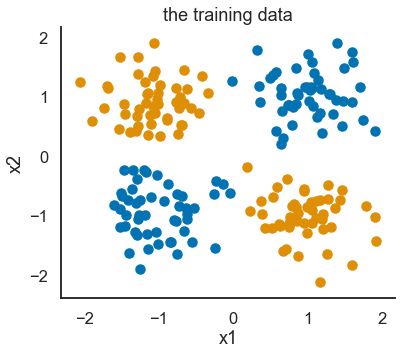

In [3]:
# generate some XOR data
n_examples = 200
x_train, y_train = make_xor_data(n_examples)
x_test, y_test = make_xor_data(n_examples)

# plot the data 
cur_palette = sns.color_palette(n_colors=2)

f, ax = plt.subplots(1,1, figsize=(6,5))
for i, y_val in enumerate(np.unique(y_train)): 
    ax.scatter(
        x_train[y_val == y_train,0],x_train[y_val == y_train,1], 
        color=cur_palette[i], 
    )
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('the training data')
sns.despine()

Now we define a simple neural network. 

In [4]:
# help funcs
hidden_layer_name = 'hidden'

def get_net(n_hidden): 
    """define a simple network"""
    model = Sequential()
    model.add(Dense(n_hidden, input_dim=2, activation='tanh',name=hidden_layer_name))
    model.add(Dense(1, activation='sigmoid',name='output'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

def get_hidden_act(model, data):
    """get neural network activity"""
    acts = get_activations(model, data)
    for layer_name in acts.keys():
        if hidden_layer_name in layer_name: 
            return acts[layer_name]

In [5]:
# model params 
n_hidden = 50
# training params
batch_size = 64
shuffle=True
n_nets = 2
n_epochs = 500

# train several models  
models = []
records = []
for i in range(n_nets): 
    model_i = get_net(n_hidden)
    record_i = model_i.fit(
        x_train, y_train, epochs=n_epochs, 
        validation_data = (x_test,y_test),
        batch_size=batch_size, shuffle=shuffle, verbose=0
    )
    models.append(model_i)
    records.append(record_i)

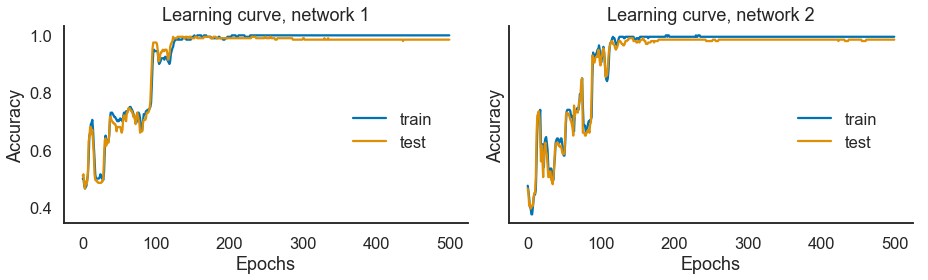

In [6]:
f, axes = plt.subplots(1,n_nets, figsize=(13,4),sharey=True)
for i,ax in enumerate(axes):
    ax.plot(records[i].history['acc'],label='train')
    ax.plot(records[i].history['val_acc'],label='test')
    ax.set_title(f'Learning curve, network {i+1}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend(frameon=False, bbox_to_anchor=(.7, .6), loc=2, borderaxespad=0)
    
sns.despine()
f.tight_layout()

#### observation: "representational similarity matrix" are similar across networks


The following figure compare the similarity between ... 
- the evoked response of stimulus i in one network 
- the evoked response of stimulus j in **the same** network 

The result shows that the two networks learn basically the same "representational similarity". That is, the relation between stimulus i and stimulus j is similar across the two networks. 

In [7]:
# test the network and get its hidden layer activity 
hidden_act_mats = [get_hidden_act(model, x_test) for model in models]

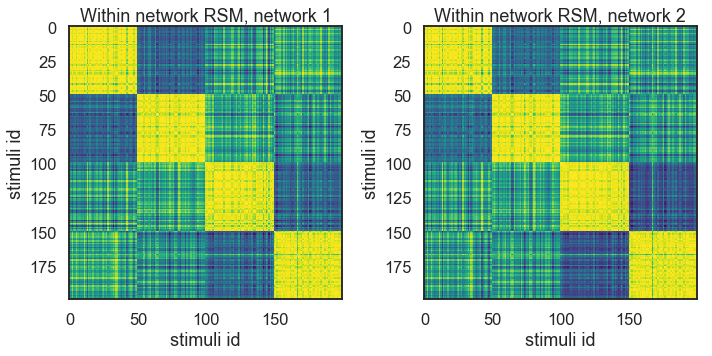

In [8]:
f,axes = plt.subplots(1, 2, figsize=(10,5))

for i, h_i in enumerate(hidden_act_mats):
    axes[i].imshow(np.corrcoef(h_i), cmap='viridis')
    axes[i].set_xlabel('stimuli id')
    axes[i].set_ylabel('stimuli id')
    axes[i].set_title(f'Within network RSM, network {i+1}')
f.tight_layout()

#### BUT: the same stimulus evoke different response patterns across the two networks

The following figure compare ... 
- evoked hidden activity pattern of stimulus i from one network 
- evoked hidden activity pattern of stimulus j from **another** network 

You can see that the following matrix doesn't reflect the consistent representational similarity structure at all :( 

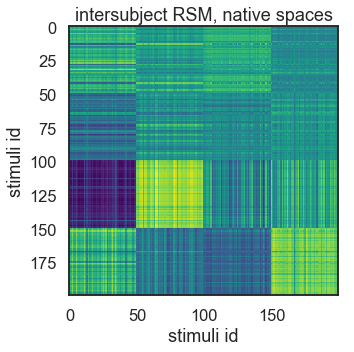

In [9]:
inter_subject_RSM = np.corrcoef(
    hidden_act_mats[0],hidden_act_mats[1]
)[:n_examples,n_examples:]

f, ax = plt.subplots(1, 1, figsize=(6,5))

ax.imshow(inter_subject_RSM, cmap='viridis')
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')
ax.set_title('intersubject RSM, native spaces')
f.tight_layout()

**But why is this the case?** What's similar across these two networks? How do these two networks encode the same similarity structure with different patterns of neural activity? 

We observed that the main reason is that they are misaligned. They have similar RSMs, which means their representational structure have the same "shape", and they can be aligned with rigid-body-transformations. 

In the two subject case, we can solve the optimal orthogonal transformation by solving the procrustes problem. However, in the more general case of aligning n networks, we need the shared response model. 

#### how to run the shared response model

The following code blocks provide a minimal example of the SRM alignment pipeline. 

*In practice, the number of components for SRM can be tuned like how you tune PCA (e.g. measure variance explained). 

In [10]:
# step 1
# get neural network activity matrices ... 
h_act_train = [get_hidden_act(model, x_train).T for model in models]
h_act_test = [get_hidden_act(model, x_test).T for model in models]

# step 2: normalize the data 
for i in range(n_nets): 
    sscalar = StandardScaler()
    sscalar.fit(h_act_train[i])
    h_act_train[i] = sscalar.transform(h_act_train[i])
    h_act_test[i] = sscalar.transform(h_act_test[i])

In [11]:
# step 3: fit SRM
n_components = n_hidden
srm = SRM(features=n_components)
# train SRM on the training set 
h_act_train_shared = srm.fit_transform(h_act_train)
# use the trained SRM to transform the test set activity
h_act_test_shared = srm.transform(h_act_test)

Once aligned, the intersubject RSM is become similar to the within-subject RSM. 

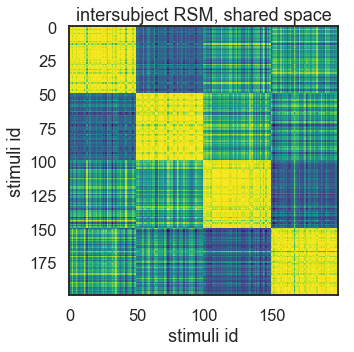

In [12]:
# compute inter-subject RSM in for the transformed activities (in the shared space)
inter_subject_RSM_shared = np.corrcoef(
    h_act_test_shared[0].T,h_act_test_shared[1].T
)[:n_examples,n_examples:]

f, ax = plt.subplots(1, 1, figsize=(6,5))

ax.imshow(inter_subject_RSM_shared, cmap='viridis')
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')
ax.set_title('intersubject RSM, shared space')
f.tight_layout()


### Thank you very much to your time!